In [1]:
from pathlib import Path
import random
import sys
sys.path.insert(0, str(Path().resolve().parent))
from src import *

# Assign a score to UV Maps to estimate the quality of the samples

##### ℹ️ This notebook requires Objaverse models in the `.objaverse/` root folder. It also requires the `statistics.parquet`.

**A sample is considered good if the overall shape of the 3D object can be inferred from its UV map.** 
If this isn't the case, it would be quite difficult for the ControlNet to effectively condition the diffusion process.

In this notebook, we ask if we can devise a good scoring function to estimate the quality of a given UV map. We will not work at the pixel level, but will use the information available in the 3D model.

In [2]:
dataset = ObjaverseDataset3D()
stats = dataset.statistics
uids = stats[(stats["valid"])].index

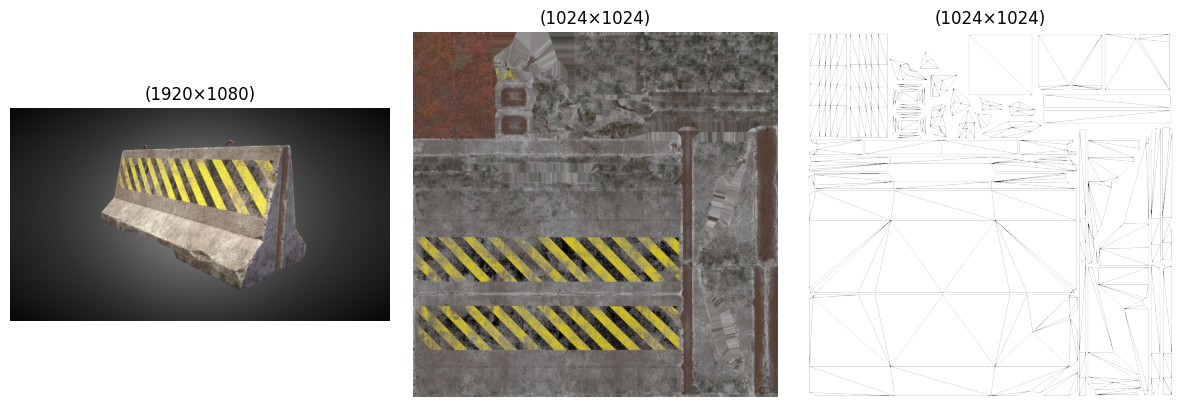

(0.5619824140808555, {'C': 1.0, 'D': 0.0002098650100498256, 'P': 0.806133475166073, 'F': 0.3019828951841236})


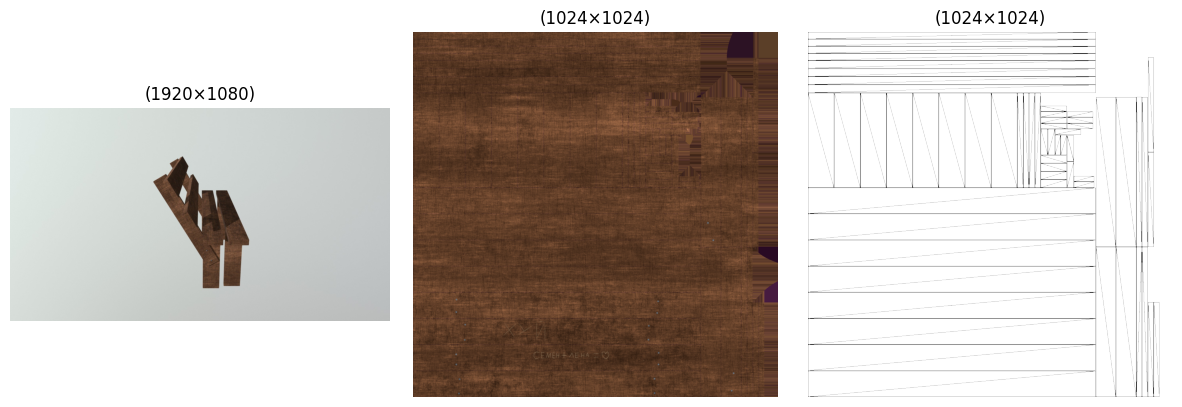

(0.550247861905365, {'C': 1.0, 'D': 1.003804709354128e-07, 'P': 0.8796937524667192, 'F': 0.15162199346783733})


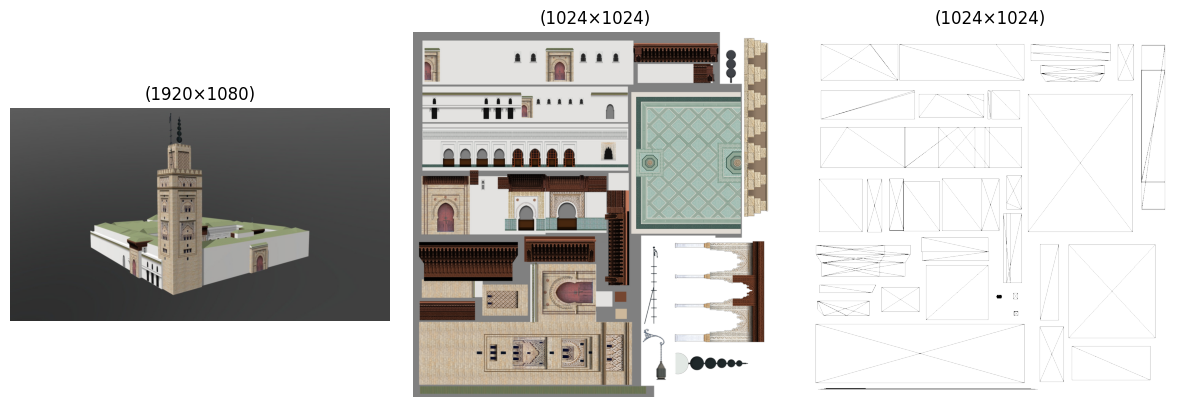

(1.0507320647811473, {'C': 1.0, 'D': 0.0013093573854722207, 'P': 2.840106517680827, 'F': 0.2018904800728628})


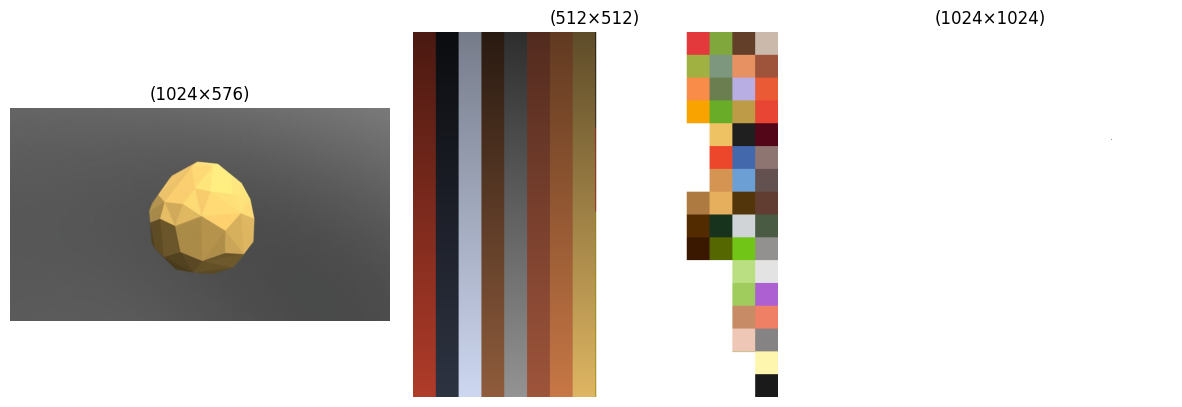

(0.310107682125616, {'C': 1.0, 'D': 0.00016261450143928435, 'P': 6.476766177598847e-06, 'F': 0.05032704654355913})


In [5]:
for uid in random.choices(uids, k=4):
    obj = dataset[uid]
    plot_images([obj.render, obj.textures[0], obj.draw_uv_map()], cols=3)
    print(obj.uv_score)

## Scoring criteria

1. **Continuity**
   UV islands that keep neighboring faces together make the shape much more reconstructible.

   * **Metric**:

     $$
       C \;=\; 1 \;-\; \frac{\#\text{cut-edges}}{\#\text{total mesh edges}}
     $$
   * Range: 0 (everything is a separate little island) to 1 (one single island).

2. **Distortion**
   Ideally, UV area should be locally proportional to 3D area (so shapes aren’t stretched or squashed).

   * For each face $f$, compute

     $$
       s_f = \frac{\text{area}_{\mathrm{UV}}(f)}{\text{area}_{3D}(f)}.
     $$
   * Then

     $$
       D = 1 - \frac{1}{1 + \sigma_s}
     $$

     where $\sigma_s$ is the standard deviation of all $s_f$.
   * Range: 0 (huge variation in per-face stretch) to approaching 1 (uniform stretch).

3. **Packing efficiency**
   How much of the 1024×1024 canvas is actually used by UV islands (vs. empty “wasted” space).

   * **Metric**

     $$
       P = \frac{\sum_f \text{area}_{\mathrm{UV}}(f)}{1024^2}.
     $$
   * Range: 0 (nothing packed) to 1 (no wasted space).

4. **Fragmentation**
   Penalize having many tiny islands (they’re “messy” to edit and imply cuts).

   * Let $N$ be number of islands, and $A_i$ each island’s area. Compute normalized entropy:

     $$
       F = 1 - \frac{-\sum_i \frac{A_i}{\sum A} \log\!\bigl(\frac{A_i}{\sum A}\bigr)}{\log N}.
     $$
   * Range: 0 (all islands equal small size – very fragmented) to 1 (one big island).


### Interpretation

* **$C$ near 1** means few UV seams: you’d see contiguous patches that hint at the whole form.
* **$D$ near 1** means low local stretch: volumes look “true,” so bumps and curves are faithfully represented.
* **$P$ near 1** means almost no wasted white space: a tidy, space-efficient layout.
* **$F$ near 1** means most area is in a few islands, not dozens of tiny scraps.